Modèle de ML qui est capable de classifier les critiques de films de la base de donnée de IMDB en fonction de si elles sont positives ou négatives.

La démarche a été la suivante :

J'utilise du transfert learning sur un language model, un modèle qui comprends la langue anglaise, déjà entraîné avec la base de donnée de Wikipedia en anglais (wikitext-103), cette démarche permet de gagner énormément de temps et d'argent. C'est un modèle entrainé pour deviner le(s) prochain(s) mot(s) d'une phrase. On prends ce language model et on va le fine tune avec notre base de donnée de critique IMDB qui contient plus de 100 000 critiques positives comme négatives de films. Une fois que c'est fait, on dispose d'un language model qui est spécialisé dans la critique de films, on va donc ensuite le transformer en Classifier pour enfin pouvoir discriminer les critiques positives et négatives.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib

J'importe ici tout ce dont j'ai besoin pour mon algo,
j'utilise Fast.ai dans sa v1, qui est une surcouche de la bibliothèque pytorch,
Fastai est une bibliothèque complète, généraliste et très modulaire.

In [2]:
from fastai.text import *

Je télécharge une version plus petite de la base de donnée IMDB à titre d'illustration

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

Les critiques prennent la forme d'un fichier csv avec trois colonnes : 

label définit si la critique est positive ou négative.

is_valid définit si la critique doit faire partie du set d'entraînement,
ou de validation

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Un exemple de critique :

In [5]:
df['text'][0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

Ici, en tâche de fond, dans les classes TextLMDatabunch (qui s'occupe de créer un language model) et TextClasDataBunch (qui s'occupe de créer un classifier), les textes sont d'abord tokenisés, les majuscules, la ponctuation, des contractions de deux mots différents, et d'autres élements implicites de la langue sont rendus explicites en étant transformés en tokens, puis ensuite les données sont numérisés : les réseaux de neurones ne reçoivent que des chiffres, il faut donc transformer les textes et les tokens en suite de chiffres pour pouvoir "nourrir" le réseau de neurones.

In [6]:
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
data_class = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)

In [7]:
data_lm.save()

Quelques critiques "tokenisées" 

In [8]:
data_class.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


Une partie de la liste des tokens enregistrés.

In [9]:
data_class.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

On télécharge ici la version complète de la base de données de critique de film IMDB

In [13]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas')]

In [14]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos')]

In [15]:
data_lm = (TextList.from_folder(path)
           # On indique où sont les données
           .filter_by_folder(include=['train', 'test', 'unsup'])
           # On indique comment séparer les données entre train et test, ici par dossiers
           .split_by_rand_pct(0.1)                               
           # On indique ici la part de critique qu'on mettra dans le validation set, ici 10%
           .label_for_lm()
           # On indique que l'on veut un language model et qu'il faut labéliser en consequence
           .databunch(bs=48))
           # On transforme le tout en une classe qui regroupe le tout
data_lm.save('data_lm.pkl')

On va ici utiliser le language model wikitext-103 pour ensuite le fine tune

In [16]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

On cherche ici le learning rate le plus adapté à notre modèle.

In [17]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [18]:
learner.recorder.plot(skip_end=15)

On commence à entraîner les premières couches de notre réseau de neurone

In [19]:
learner.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.130412,4.022075,0.295426,23:39


In [20]:
learner.save('fit_head')
learner.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj jiang xxmaj xian uses the complex backstory of xxmaj ling xxmaj ling and xxmaj mao xxmaj xxunk to study xxmaj mao 's " cultural revolution " ( 1966 - 1976 ) at the village level . xxmaj the film has the elements and pace of xxmaj chinese opera and so appears slow and sometimes sentimental to the foreign viewer . xxmaj but the movie provides a window onto contemporary life in xxmaj china , with its focus upon villagers in the city , the consuming quality of subsistence -- daily struggle , family and local cruelties -- and the appeal of movies as escape , fantasy , and , ultimately , as source of community . xxmaj this last is the most radical element in the film , for it suggests the modern -- and universal -- experience of culture will replace the insular xxmaj chinese traditions . xxmaj the child actors are particularly fine .,xxbos xxmaj sheesh ! xxmaj it is amazing how much control the xx

On "unfreeze" ici le modèle, on indique donc ainsi qu'il faut entraîner le modèle entier.

In [22]:
learner.unfreeze()
learner.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.861368,3.812679,0.317656,26:42
1,3.826183,3.772185,0.325173,26:38
2,3.803324,3.742379,0.329288,26:44
3,3.699888,3.704858,0.333616,26:43
4,3.659085,3.676335,0.337051,26:46
5,3.591513,3.650991,0.339977,26:54
6,3.524016,3.632524,0.342284,26:47
7,3.458857,3.621678,0.344063,26:48
8,3.413003,3.619142,0.344461,26:47
9,3.391668,3.620793,0.344347,26:46


In [24]:
learner.save('LSTM_ft-IMDB_LM')

In [25]:
learner.save_encoder('LSTM_ft-IMDB_enc')

In [27]:
(path/'models').ls()

[PosixPath('/root/.fastai/data/imdb/models/tmp.pth'),
 PosixPath('/root/.fastai/data/imdb/models/fit_head.pth'),
 PosixPath('/root/.fastai/data/imdb/models/LSTM_ft-IMDB_LM.pth'),
 PosixPath('/root/.fastai/data/imdb/models/LSTM_ft-IMDB_enc.pth')]

On fais tourner notre language model et on le fait parler :

In [12]:
TEXT = "The film is about a computer student passionate \
about machine learning who is looking for an internship"
N_WORDS = 40
print(TEXT)

The film is about a computer student passionate about machine learning who is looking for an internship


In [13]:
print(learner.predict(TEXT, N_WORDS, temperature=0.75))

The film is about a computer student passionate about machine learning who is looking for an internship at a high - tech corporation that is working on the Internet . It 's the only way his work is able to get past his current computer , which he by then has to deal with .


On passe finalement à un classifier, une fois avoir fine tune notre language model, qui est maintenant spécialisé dans la critique de films.

In [14]:
data_class = (TextList.from_folder(path, vocab=data_lm.vocab)
              .split_by_folder(valid='test')
              .label_from_folder(classes=['neg', 'pos'])
              .databunch(bs=48))

Nous avons juste besoin de l'encoder pour notre classifier

In [15]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder("/kaggle/input/encoder/LSTM_ft-IMDB_enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj following the success of " xxmaj paris , xxmaj je t'aime " , a group of directors decided to get together and make a similar anthology style film based in xxmaj new xxmaj york . xxmaj unlike the original film , the stories in this film seem to sometimes come and go too quickly -- by the time you think are getting into a story , it 's over in too many cases . xxmaj and , the often start up and stop and then begin again -- with the stories woven together . xxmaj as a result , there is no title to indicate that a story is complete and it is less formal in structure . 
 
  xxmaj sadly , however , while " xxmaj paris , xxmaj je t'aime " was hit or miss ( mostly hit ) , most of " xxmaj new xxmaj york , i xxmaj love xxmaj you " was miss . xxmaj the stories tended to be much more sexual in nature but also far less sweet -- and often quite terrible . xxmaj it was an amazingly dull and uninteresting film w

On entraîne maintenant notre Classifier

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


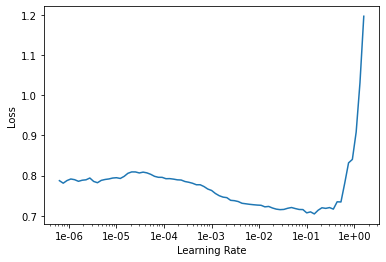

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.586578,0.530594,0.736280,02:56
1,0.560701,0.511602,0.750440,02:57
2,0.545414,0.498788,0.757280,03:16


In [19]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.448688,0.391573,0.819360,03:39


In [20]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.353943,0.301778,0.869720,05:19


In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


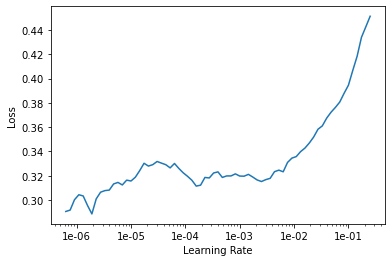

In [22]:
learn.recorder.plot()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.301540,0.290188,0.877520,06:29
1,0.277834,0.278209,0.883280,05:58
2,0.254483,0.278802,0.882440,05:50


On peut finalement utiliser notre modèle pour prédire si notre critique est positive ou négative, qui marche plutôt bien.

In [24]:
learn.predict("I really loved that movie, it was awesome!")

(Category tensor(1), tensor(1), tensor([0.0016, 0.9984]))

In [25]:
learn.predict("This film was very bad")

(Category tensor(0), tensor(0), tensor([9.9968e-01, 3.1899e-04]))